In [2]:
#use the Q2 2016 data first
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]


570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


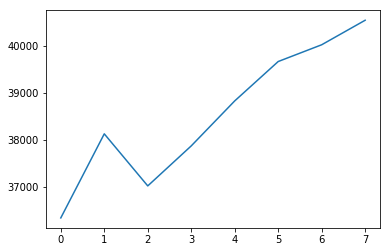

In [5]:
#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

In [6]:
yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]

In [7]:
fs = 18
fs_ = 20
_fs = 16

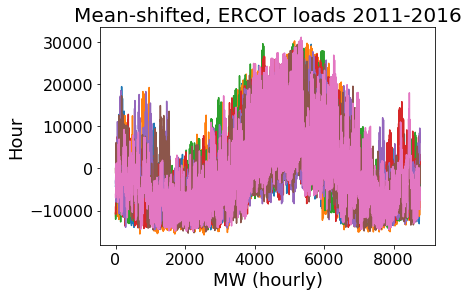

In [8]:
ax = plt.axes()
plt.title("Mean-shifted, ERCOT loads 2011-2016", fontsize=fs_)
plt.ylabel("Hour", fontsize=fs)
plt.xlabel("MW (hourly)", fontsize=fs)
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
for i in range(7):
    plt.plot(yearly_loads[i,:])
plt.show()

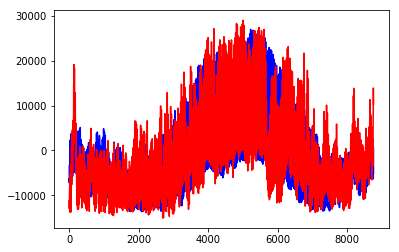

In [9]:
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue")
plt.plot(test, color="red")

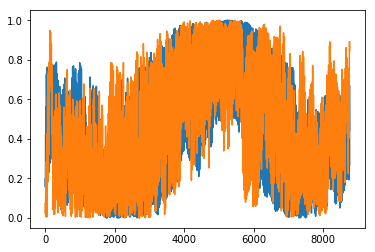

In [22]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

for i in range(model_ranks.shape[0]):
    greater = np.sum([ 1 for k in model[:,] if k >= model[i,] ])/float(model.shape[0])
    model_ranks[i,0] = 1.0 - greater
    
for i in range(test_ranks.shape[0]):
    greater = np.sum([ 1 for k in test[:,] if k >= test[i,] ])/float(test.shape[0])
    test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks)
plt.plot(test_ranks)

In [40]:
def binary_rec(labels, pred, thresh=0.85):
    pred_pos = 0 #values I've predicted above a threshold (numerator)
    all_pos = 0 #all true positives in test data (denominator)
    for i in range(len(labels)):
        if labels[i] >= thresh:
            all_pos += 1
            if pred[i] >= thresh:
                pred_pos += 1
    if all_pos == 0:
        return(np.nan)
    else:
        return(float(pred_pos)/float(all_pos))
    
def binary_prec(labels, pred, thresh=0.85):
    pred_pos = 0 #values I've predicted above a threshold (denominator)
    true_pos = 0 #positives I've correctly predicted (numerator)
    for i in range(len(pred)):
        if pred[i] >= thresh:
            pred_pos += 1
            if labels[i] >= thresh:
                true_pos += 1
    if pred_pos == 0:
        return(np.nan)
    else:
        return(float(true_pos)/float(pred_pos))

def thresh_loss(labels, pred, thresh=0.85):
    out = []
    for i in range(len(labels)):
        if pred[i] >= thresh or labels[i] >= thresh:
            loss = np.abs(labels[i] - pred[i])
            out.append(loss)
    if len(out) == 0:
        out = np.nan
    else:
        pass
    return(np.nanmean(out))

def eval_perf_dropoff(labels, pred):
    thresh_losses = np.arange(0.85,0.99,0.01)
    
    out_prec = []
    out_rec = []
    out_loss = []
    out_false_pos = []
    out_false_neg = []
    
    for t in thresh_losses:
        out_prec.append(binary_prec(labels, pred, t))
        out_rec.append(binary_rec(labels, pred, t))
        out_loss.append(thresh_loss(labels, pred, t))
        out_false_pos.append(binary_false_pos(labels, pred, t))
        out_false_neg.append(binary_false_neg(labels, pred, t))
        
    return(out_prec, out_rec, out_loss, out_false_pos, out_false_neg)

def torch_reshape_data(databatch):
    #flattens array inputs for a single list of training, target pairs
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

def binary_false_pos(labels, pred, thresh=0.85):
    false_pos = 0
    for i in range(len(labels)):
        if pred[i] >= thresh and labels[i] < thresh:
            false_pos += 1
    g1 = sum([1 for j in labels if j >= thresh])
    g2 = sum([1 for j in pred if j >= thresh])
    greater = g1 + g2
    if greater == 0:
        return(np.nan)
    else:
        return(float(false_pos)/float(greater))

def binary_false_neg(labels, pred, thresh=0.85):
    false_neg = 0
    for i in range(len(labels)):
        if pred[i] < thresh and labels[i] >= thresh:
            false_neg += 1
    g1 = sum([1 for j in labels if j >= thresh])
    g2 = sum([1 for j in pred if j >= thresh])
    greater = g1 + g2
    if greater == 0:
        return(np.nan)
    else:
        return(float(false_neg)/float(greater))

In [29]:
out_prec, out_rec, out_loss, out_false_pos, out_false_neg = eval_perf_dropoff(test_ranks, model_ranks)

In [30]:
np.max(test_ranks)

0.9998858447488584

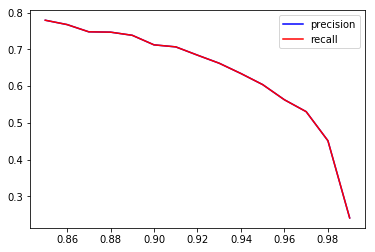

In [51]:
thresh_losses = np.arange(0.85,0.99,0.01)
plt.plot(thresh_losses, out_prec, color="blue", label="precision")
plt.plot(thresh_losses, out_rec, color="red", label="recall")
plt.legend()

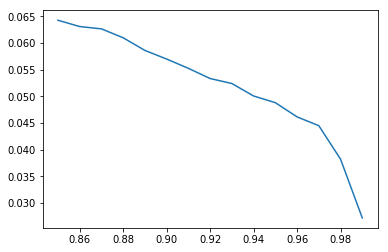

In [32]:
plt.plot(thresh_losses, out_loss)

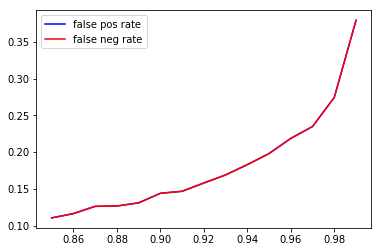

In [33]:
plt.plot(thresh_losses, out_false_pos, color="blue", label="false pos rate")
plt.plot(thresh_losses, out_false_neg, color="red", label="false neg rate")
plt.legend()

In [34]:
#compare to a neural net
#this was a load-only model that did well:
path = "/home/chase/projects/peakload/data/nets/models/"
mname = 'tanh_sigmoid_LOOKBACK_168_HIDDEN_1_1000_HIDDEN_2_250_HIDDEN_3_250_LOSS_EW_EPOCHS_100_9580.pt'

sys.path.append("/home/chase/projects/peakload/src/python/nets/tanh_hidden")

nnmodel = torch.load(path + mname)

In [35]:
random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

test_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_test_data_pairs.pck"
with open(test_data_path, 'rb') as d:
    normed_test_data_pairs = pickle.load(d)

In [36]:
#do prediction on test data
inputs, labels = torch_reshape_data(normed_test_data_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()

In [45]:


prec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
rec = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
loss = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_pos = np.zeros((outputs.shape[0], thresh_losses.shape[0]))
false_neg = np.zeros((outputs.shape[0], thresh_losses.shape[0]))

for i in range(outputs.shape[0]):
    nout_prec, nout_rec, nout_loss, nout_false_pos, nout_false_neg = eval_perf_dropoff(labels[i,:], outputs[i,:])
    prec[i,:] = np.array(nout_prec)
    rec[i,:] = np.array(nout_rec)
    loss[i,:] = np.array(nout_loss)
    false_pos[i,:] = np.array(nout_false_pos)
    false_neg[i,:] = np.array(nout_false_neg)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice


In [49]:
nout_prec = np.nanmean(prec, axis=0)
nout_rec = np.nanmean(rec, axis=0)
nout_loss = np.nanmean(loss, axis=0)
nout_false_pos = np.nanmean(false_pos, axis=0)
nout_false_neg = np.nanmean(false_neg, axis=0)

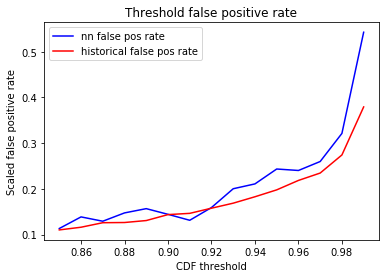

In [57]:

plt.plot(thresh_losses, nout_false_pos, color="blue", label="nn false pos rate")
plt.plot(thresh_losses, out_false_pos, color="red", label = "historical false pos rate")
plt.title("Threshold false positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false positive rate")
plt.legend()

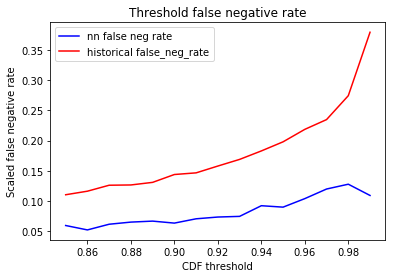

In [56]:
plt.plot(thresh_losses, nout_false_neg, color="blue", label="nn false neg rate")
plt.plot(thresh_losses, out_false_neg, color="red", label="historical false_neg_rate")
plt.title("Threshold false negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Scaled false negative rate")
plt.legend()

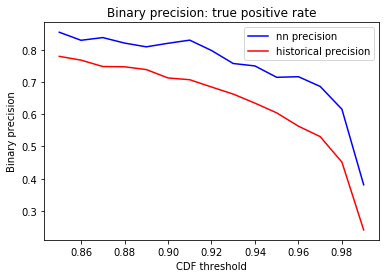

In [54]:

plt.plot(thresh_losses, nout_prec, color="blue", label="nn precision")
plt.plot(thresh_losses, out_prec, color="red", label = "historical precision")
plt.title("Binary precision: true positive rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary precision")
plt.legend()

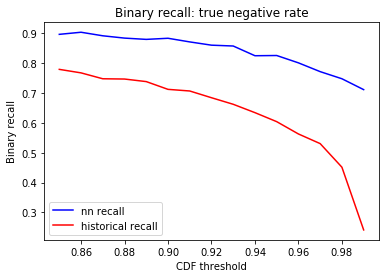

In [52]:
plt.plot(thresh_losses, nout_rec, color="blue", label="nn recall")
plt.plot(thresh_losses, out_rec, color="red", label = "historical recall")
plt.title("Binary recall: true negative rate")
plt.xlabel("CDF threshold")
plt.ylabel("Binary recall")
plt.legend()

Text(0,0.5,'L1 Loss')

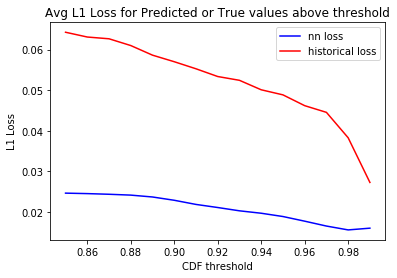

In [53]:
plt.plot(thresh_losses, nout_loss, color="blue", label="nn loss")
plt.plot(thresh_losses, out_loss, color="red", label="historical loss")
plt.legend()
plt.title("Avg L1 Loss for Predicted or True values above threshold")
plt.xlabel("CDF threshold")
plt.ylabel("L1 Loss")

In [139]:
out_prec

[0.7792998477929984,
 0.768352365415987,
 0.7486818980667839,
 0.7469077069457659,
 0.7383177570093458,
 0.7134703196347032,
 0.7081218274111675,
 0.6857142857142857,
 0.6623164763458401,
 0.6342857142857142,
 0.6041189931350115,
 0.5628571428571428,
 0.5343511450381679,
 0.4514285714285714,
 0.2413793103448276,
 nan]